# Multiplicity determination with super-basic Bayesian Statistics

In [1]:
label = "nPN"
nmax = 4

In [2]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import (
    balanced_accuracy_score,
    confusion_matrix,
    plot_confusion_matrix,
)

sys.path.append("..")
from helpers import tridata

In [3]:
class Bayes:
    def __init__(self, train, max_neutrons, label):
        # Hypotheses: Zero to max neutrons
        self._hypos = range(0, max_neutrons + 1)

        # 'Fit' -> Create PDF for all numbers of neutrons
        # TODO: Should they be normalized?
        self._hits = {
            h: np.histogram(train[train[label] == h]["nHits"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._clus = {
            h: np.histogram(train[train[label] == h]["nClus"], range=(0, 500), bins=500, density=True,)[0]
            for h in self._hypos
        }
        self._edep = {
            h: np.histogram(train[train[label] == h]["Edep"], range=(0, 5000), bins=500, density=True,)[0]
            for h in self._hypos
        }

    def predict(self, x):
        # 'Predict' -> Use PDFs to get probabilities and take the highest
        probs = [
            self._hits[h][x["nHits"]] * self._clus[h][x["nClus"]] * self._edep[h][x["Edep"].floordiv(10).astype(int)]
            for h in self._hypos
        ]
        y_pred = np.argmax(probs, axis=0)
        return y_pred

In [4]:
traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=nmax, physics="inclxx")

## Example Fit / Calibration & Prediction

In [5]:
model = Bayes(traindata, nmax, label)
y_pred = model.predict(testdata)
y_true = testdata[label].values.ravel()

print(list(zip(y_true, y_pred))[0:50])

[(2, 2), (4, 4), (3, 3), (2, 2), (1, 1), (3, 3), (1, 1), (1, 1), (2, 3), (4, 4), (2, 3), (3, 2), (1, 1), (4, 3), (3, 2), (3, 3), (4, 4), (1, 1), (1, 1), (4, 3), (3, 3), (3, 3), (4, 1), (3, 3), (4, 3), (3, 3), (4, 4), (1, 1), (3, 4), (3, 2), (2, 2), (1, 1), (3, 3), (4, 4), (4, 4), (3, 3), (2, 2), (4, 3), (1, 1), (2, 3), (1, 2), (2, 2), (2, 2), (2, 2), (2, 2), (1, 1), (4, 3), (4, 4), (3, 2), (1, 1)]


In [6]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

bac = balanced_accuracy_score(y_true, y_pred)
print(bac)
cm = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1))
print(cm)
cmrel = confusion_matrix(y_true, y_pred, labels=range(0, nmax + 1), normalize="true")
print((cmrel * 100).round())

0.7415771207523474
[[ 2109     0     0     0     0]
 [    0 33758  4009    30     6]
 [    1  8038 24105  7521   235]
 [    2  1244  8970 20153  9825]
 [    3   142  1959  9501 28324]]
[[100.   0.   0.   0.   0.]
 [  0.  89.  11.   0.   0.]
 [  0.  20.  60.  19.   1.]
 [  0.   3.  22.  50.  24.]
 [  0.   0.   5.  24.  71.]]


Text(69.0, 0.5, 'True')

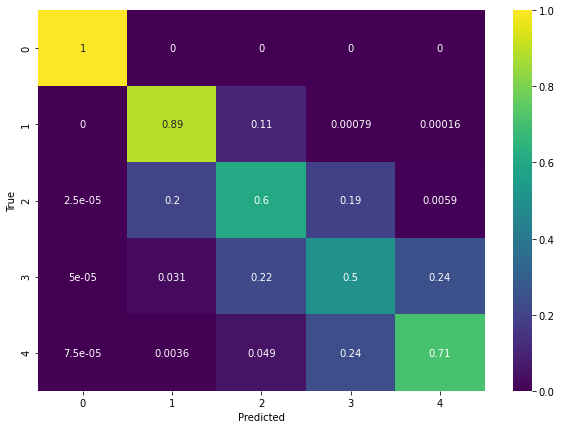

In [7]:
plt.figure(figsize=(10, 7))
ax = sns.heatmap(cmrel, cmap="viridis", annot=True)
ax.set_xlabel("Predicted")
ax.set_ylabel("True")

## Evaluation for different max multiplicities

In [8]:
for n in [1, 2, 3, 4, 5]:
    traindata, testdata = tridata(distance=15, doubleplane=30, energy=600, erel=500, nmax=n, physics="inclxx")

    model = Bayes(traindata, n, label)
    y_pred = model.predict(testdata)
    y_true = testdata[label].values.ravel()

    bac = balanced_accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred, labels=range(0, n + 1))
    print(cm)
    print(n, bac)

[[ 1982     0]
 [   12 38143]]
1 0.9998427466911283
[[ 2112     0     0]
 [    4 33885  4252]
 [    8  8079 31641]]
2 0.8949516133512541
[[ 2089     0     0     0]
 [    1 34161  4188    47]
 [    2  8047 23879  7816]
 [    3  1208  8932 29946]]
3 0.8093717706418108
[[ 2071     0     0     0     0]
 [    3 33583  4133    29     8]
 [    0  8229 24021  7451   209]
 [    0  1195  8920 19748  9790]
 [    3   145  1831  9578 28166]]
4 0.7396868634755174
[[ 2110     0     0     0     0     0]
 [    0 33977  4134    32     7     3]
 [    0  8109 24036  7581   200     5]
 [    2  1216  9010 19741  9120   718]
 [    2   156  1892  9625 17263 11050]
 [    6     9   291  2647  9448 27527]]
5 0.684920427798983
